In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt

In [3]:
!unzip /content/drive/MyDrive/images.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/ggeorg.19.jpg    
  inflating: images/ggeorg.2.jpg     
  inflating: images/ggeorg.20.jpg    
  inflating: images/ggeorg.3.jpg     
  inflating: images/ggeorg.4.jpg     
  inflating: images/ggeorg.5.jpg     
  inflating: images/ggeorg.6.jpg     
  inflating: images/ggeorg.7.jpg     
  inflating: images/ggeorg.8.jpg     
  inflating: images/ggeorg.9.jpg     
  inflating: images/gghazv.1.jpg     
  inflating: images/gghazv.10.jpg    
  inflating: images/gghazv.11.jpg    
  inflating: images/gghazv.12.jpg    
  inflating: images/gghazv.13.jpg    
  inflating: images/gghazv.14.jpg    
  inflating: images/gghazv.15.jpg    
  inflating: images/gghazv.16.jpg    
  inflating: images/gghazv.17.jpg    
  inflating: images/gghazv.18.jpg    
  inflating: images/gghazv.19.jpg    
  inflating: images/gghazv.2.jpg     
  inflating: images/gghazv.20.jpg    
  inflating: images/gghazv.3.jpg     
  inflating: images/

In [101]:
GENERATE_RES = 2 # Множитель разрешения
# Изображение должно быть квадратным (в данном случае размер будет кратен 32)
# Чем больше разрешение, тем больше нужно памяти
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

# Таблица предпросмотра
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Длина случайного вектора для генераци изображения
SEED_SIZE = 100

# Настройки
DATA_PATH = '/content'  # Путь в котором будут находится все нужныфе файлы
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

In [5]:
# Подгоняем размер изображений под нужное квадратное
# Делаем их черно-белыми
# Переводим их в векторное представление
# Записываем массив получившихся изображений в бинарный файл
training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

if not os.path.isfile(training_binary_path):
  training_data = []
  faces_path = os.path.join(DATA_PATH, 'images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path, filename)
      image = Image.open(path).resize(
          (GENERATE_SQUARE, GENERATE_SQUARE),
          Image.ANTIALIAS
      )
      training_data.append(np.asarray(image))
  training_data = np.reshape(
      training_data,
      (-1, GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)
  )
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.

  np.save(training_binary_path, training_data)
else:
  training_data = np.load(training_binary_path)

  0%|          | 0/7864 [00:00<?, ?it/s]<ipython-input-5-3088693899cf>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS
100%|██████████| 7864/7864 [00:09<00:00, 799.91it/s]


In [7]:
# Перемешиваем изображения и разбиваем на батчи
train_dataset = tf.data.Dataset \
    .from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE)

In [8]:
# Строим модели генератора и дискриминатора
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4 * 4 * 256, activation="relu", input_dim=seed_size))
    model.add(Reshape((4, 4, 256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES > 1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128, kernel_size=3, padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [9]:
# Сохранение изображений для каждой эпохи
def save_images(cnt, noise):
  image_array = np.full((
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)),
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), IMAGE_CHANNELS),
      255, dtype=np.uint8)

  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE + 16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE + 16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1


  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)

  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

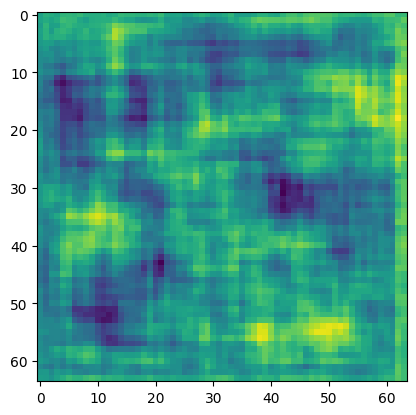

In [92]:
# Генерируем изображение на основе шума при необученной модели
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [93]:
image_shape = (GENERATE_SQUARE, GENERATE_SQUARE, IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49984413]], shape=(1, 1), dtype=float32)


In [94]:
# Функции потерь
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [96]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [97]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)


    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  return gen_loss, disc_loss

In [100]:
def train(dataset, epochs):
  # Фиксированный шум для генерации предпросмотра на каждой эпохе
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time() - epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss}, disc loss={d_loss}, time: {(epoch_elapsed)}')
    save_images(epoch, fixed_seed)

  elapsed = time.time() - start
  print (f'Training time: {(elapsed)}')

In [102]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=2.499565601348877, disc loss=0.8343230485916138, time: 23.956085920333862
1/1 [==============================] - 0s 123ms/step
Epoch 2, gen loss=2.9213500022888184, disc loss=0.719196617603302, time: 16.715254306793213
1/1 [==============================] - 0s 24ms/step
Epoch 3, gen loss=2.2745602130889893, disc loss=0.9496539235115051, time: 16.824214696884155
1/1 [==============================] - 0s 26ms/step
Epoch 4, gen loss=2.01444935798645, disc loss=0.9716974496841431, time: 16.99930691719055
1/1 [==============================] - 0s 17ms/step
Epoch 5, gen loss=1.8657797574996948, disc loss=1.003098487854004, time: 17.034242868423462
1/1 [==============================] - 0s 16ms/step
Epoch 6, gen loss=1.8960717916488647, disc loss=0.9895050525665283, time: 17.162055730819702
1/1 [==============================] - 0s 17ms/step
Epoch 7, gen loss=1.951103687286377, disc loss=0.9649840593338013, time: 17.23956060409546
1/1 [==============================] - 0s 23

In [103]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


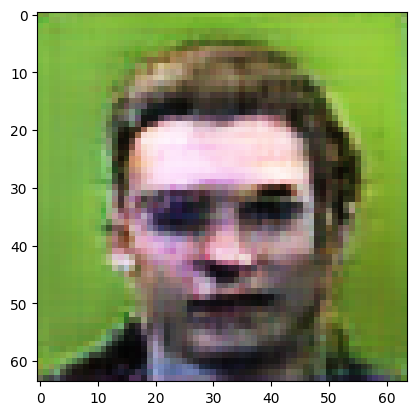

In [129]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator.predict(noise)

plt.imshow(generated_image[0, :, :, :] * 0.5 + 0.5)